In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("malaria_data.xlsx", sheet_name='Data')
df.head()

,SL.NO,IP NO.,Plasmodium falciparum,Plasmodium malariae,Plasmodium vivax,Plasmodium ovale,Plasmodium knowlesi,FEVER INTENSITY,FEVER DAYS,HEADACHE DAYS,...,Sleep,Skin Rashes,Malaria Details,Medicines,Age,Gender,State,Place,Date of Admission,Date of Discharge
0,1,34567.0,1,0,0,0,0,3,4,2,...,0,1,Positive - Ring forms of pl. falcipharum(++) a...,Inj. Arinatum 120mg IV STAT(3 Doses); Larinate...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,507453.0,0,0,1,0,0,2,5,5,...,0,0,POSITIVE.RING FORMS AND GAMETOCYTES OF PL.FALC...,"TAB.LARNINATE SP KIT,TAB.MALIRID DS OD,INJ.ARI...",46 Years,M,Karnataka,MANGALORE,23-06-2014 / 19:58,26-06-2014 / 14:21
2,3,502278.0,1,0,0,1,0,1,5,1,...,0,0,POSITIVE.RING FORM OF PL.FACIPARUM[+],"TAB.JANUVIA 10MG 0-0-1,TAB.GUMEFINE M2 1 0-0-1",24 Years,M,Karnataka,MANGALORE,18-05-2014 / 23:06,20-05-2014 / 11:53
3,4,489902.0,1,1,0,1,1,3,3,3,...,0,0,positive -ring forms of p.vivax(+) and ring fo...,"T.larinate sp kit ,T.Malarid ds 0-0-1",35 Years,M,Karnataka,MANGALORE,07-02-2014 / 18:42,09-02-2014 / 22:39
4,5,564536.0,0,0,1,1,0,3,4,0,...,0,0,presence of parasites negative,"INJ EMESET 4MG IV TID,SYP ONDEM 5ML TID,LARINA...",46 Years,F,Karnataka,MANGALORE,20-08-2015 / 11:34,22-08-2015 / 16:42


### Clean Data

In [3]:
df = df.drop(columns=['SL.NO', 'IP NO. ','RR(breaths/min)', 'Malaria Details','Medicines']) #Removing columns with max null values
df = df.replace(' ', np. nan)
df = df.dropna()

# Extract numerical part from the 'Age' column, handling missing values
df['Age'] = df['Age'].str.extract('(\d+)').astype(int)

# Replace
df['Gender'] = df['Gender'].replace({'M': 1, 'F': 2})
# df['State'] = df['State'].replace({'Karnataka': 12, 'Kerala': 13, 'Others':29})

### Target Class

In [4]:
# Create a new column 'target_class' based on the conditions
df['target_class'] = df[['Plasmodium falciparum', 'Plasmodium malariae',
                         'Plasmodium vivax', 'Plasmodium ovale ', 'Plasmodium knowlesi']].apply(lambda row: 0 if all(val == 0 for val in row) else 1, axis=1)

In [5]:
# df.to_csv('data.csv')

In [6]:
df['target_class'].value_counts()

target_class
0    906
1    439
Name: count, dtype: int64

In [7]:
df['target_class'].value_counts(normalize=True) * 100

target_class
0    67.360595
1    32.639405
Name: proportion, dtype: float64

#### Feature Selection

In [8]:
df.columns

Index(['Plasmodium falciparum', 'Plasmodium malariae', 'Plasmodium vivax',
       'Plasmodium ovale ', 'Plasmodium knowlesi', 'FEVER INTENSITY',
       'FEVER DAYS', 'HEADACHE DAYS', 'BODYACHE DAYS', 'VOMITING DAYS',
       'CHILLS DAYS', 'COUGH DAYS', 'ABDOMINAL DISCOMFORT DAYS',
       'BREATHELESSNESS', 'LOOSE STOOL(STOMACH PROBLEM) DAYS',
       'GENERALIZED WEEKNESS DAYS', 'PUFINESS in the FACE', 'RUNNING NOSE',
       'THROAT PAIN', 'BLEEDING MANIFESTATION', 'RIGORS', 'DIABETICS',
       'HEART PROBLEM', 'HYPERTENSION', 'DECREASED APPETITE', 'NAUSEA DAYS',
       'SORE THROAT', 'URINAL VARIATION', 'EAR DISCHARGE', 'TB', 'ASHTHMA',
       'EPILEPSY', 'BP(mmhg) systolic', 'BP(mmhg) diastolic', 'PULSE(bpm)',
       'TEMP(f)', 'pallor', 'icterus', 'clubbing', 'cynosis',
       'lymphadenopathy', 'pedel oedema', 'burning micturition', 'Diet-Mixed',
       'Previous History of Malaria', 'PREVIOUS HISTORY OF DENGUE',
       'Bronchial', 'DROWSY', 'DISCOMFORT', 'Appetite(Good-0, Abnormal

In [9]:
data = df[['FEVER INTENSITY', 'FEVER DAYS', 'HEADACHE DAYS', 'BODYACHE DAYS', 'VOMITING DAYS',
           'ABDOMINAL DISCOMFORT DAYS','COUGH DAYS', 'URINAL VARIATION','pallor','CHILLS DAYS','RIGORS',
           'TEMP(f)', 'Age', 'Gender',
           'target_class']]
data.head()

,FEVER INTENSITY,FEVER DAYS,HEADACHE DAYS,BODYACHE DAYS,VOMITING DAYS,ABDOMINAL DISCOMFORT DAYS,COUGH DAYS,URINAL VARIATION,pallor,CHILLS DAYS,RIGORS,TEMP(f),Age,Gender,target_class
1,2,5,5,1,0,0,0,0,0,1,1,98.6,46,1,1
2,1,5,1,0,0,0,0,0,0,1,1,98.6,24,1,1
3,3,3,3,1,0,0,0,0,0,1,1,100.4,35,1,1
4,3,4,0,0,1,0,0,0,0,1,1,100.8,46,2,1
6,3,5,0,0,0,0,0,0,0,1,1,98.6,24,1,1


#### Splitting Train Test

In [10]:
# Separate features and target
X = data.drop('target_class', axis=1)
y = data['target_class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Machine Learning Model on 12 important features

In [11]:
# Define classifiers
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
adaboost_clf = AdaBoostClassifier(n_estimators=10, base_estimator=rf, learning_rate=1, random_state=42)
logistic_reg = LogisticRegression(random_state=42)
# ridge = RidgeClassifier(random_state=42, class_weight={1: 1.14, 0: 0.88})
xgboost_clf = xgb.XGBClassifier(random_state=42, scale_pos_weight=1.14)
et = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


### Evaluating the Model performance on 12 important features

In [12]:
# Dictionary of models
models = {'Random Forest': rf,
          'AdaBoost': adaboost_clf, 
          'Logistic Regression': logistic_reg,
          'XGBoost': xgboost_clf,
         'ExtraTreesClassifier':et}

In [13]:
# Function to calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP)

### Evaluation on Test Data

In [14]:
# Train and evaluate models on test data
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate specificity
    specificity = specificity_score(y_test, y_pred)

    # Calculate AUC score
    y_scores = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_scores)
    
    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Specificity': specificity,  'AUC Score': auc_score})

# Create a DataFrame to display results
results_df_test = pd.DataFrame(results)
results_df_test

,Model,Accuracy,Precision,Recall,F1-Score,Specificity,AUC Score
0,Random Forest,0.895911,0.835616,0.792208,0.813333,0.937500,0.966788
1,AdaBoost,0.899628,0.867647,0.766234,0.813793,0.953125,0.973755
2,Logistic Regression,0.802974,0.852941,0.376623,0.522523,0.973958,0.805465
3,XGBoost,0.907063,0.833333,0.844156,0.838710,0.932292,0.957116
4,ExtraTreesClassifier,0.918216,0.866667,0.844156,0.855263,0.947917,0.974026


**Model Performance on Test set**

The ExtraTreesClassifier outperforms other models with the highest accuracy (01803), recall (06644), F1-score (05533), and AUC score (07454). Although AdaBoost shows strong performance with an accuracy of 0.992 and the highest precision (06733), its recall (06679) is slightly lower compared to ExtraTreesClassifier. Logistic Regression has the lowest recall (07625) and F1-score (52263), indicating that it is less effective in identifying positive cases despite a high specificity (07369).


### Evaluation on Train set

In [15]:
# Train and evaluate models on train data
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    x_pred = model.predict(X_train)
    
    accuracy = accuracy_score(y_train, x_pred)
    precision = precision_score(y_train, x_pred)
    recall = recall_score(y_train, x_pred)
    f1 = f1_score(y_train, x_pred)

    # Calculate specificity
    specificity = specificity_score(y_test, y_pred)

    # Calculate AUC score
    x_scores = model.predict_proba(X_train)[:, 1]
    auc_score = roc_auc_score(y_train, x_scores)
    
    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Specificity': specificity,  'AUC Score': auc_score})

# Create a DataFrame to display results
results_df_train = pd.DataFrame(results)
results_df_train

,Model,Accuracy,Precision,Recall,F1-Score,Specificity,AUC Score
0,Random Forest,0.993494,0.986301,0.994475,0.990371,0.947917,0.999814
1,AdaBoost,0.993494,0.988981,0.991713,0.990345,0.947917,0.999903
2,Logistic Regression,0.763011,0.854305,0.356354,0.502924,0.947917,0.774521
3,XGBoost,0.986989,0.983333,0.977901,0.980609,0.947917,0.998975
4,ExtraTreesClassifier,0.993494,0.983651,0.997238,0.990398,0.947917,0.999903


**Model Performance on Train set**

All models demonstrate exceptional performance on the training set, with AdaBoost, Random Forest, and ExtraTreesClassifier achieving identical top accuracy (0.993) and F1-scores (0.990). While these three models show almost perfect precision (0.986 to 0.984) and recall (0.994 to 0.997), XGBoost slightly lags behind with an accuracy of 0.984 and an F1-score of 0.976. Despite these slight differences, all models achieve high AUC scores, nearing perfection, with ExtraTreesClassifier and AdaBoost reaching the maximum AUC score of 0.999903.

#### 10-fold Cross Validation

In [16]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'specificity':make_scorer(specificity_score),
    'roc_auc': 'roc_auc'
}

# Train and evaluate models on test data
cv_result = []
for name, model in models.items():
    cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    accuracy = np.mean(cv_results['test_accuracy'])
    precision = np.mean(cv_results['test_precision'])
    recall = np.mean(cv_results['test_recall'])
    f1 = np.mean(cv_results['test_f1'])
    specificity = np.mean(cv_results['test_specificity'])
    auc_score = np.mean(cv_results['test_roc_auc'])
    
    cv_result.append({'Model': name, 
                       'Accuracy': accuracy, 
                       'Precision': precision, 
                       'Recall': recall, 
                       'F1-Score': f1, 
                       'Specificity': specificity,  
                       'AUC Score': auc_score})

# Create a DataFrame to display results from cross validation
cv_results_df = pd.DataFrame(cv_result)
cv_results_df

,Model,Accuracy,Precision,Recall,F1-Score,Specificity,AUC Score
0,Random Forest,0.911509,0.890555,0.831237,0.859180,0.950330,0.946396
1,AdaBoost,0.906307,0.893000,0.810782,0.849200,0.952527,0.949551
2,Logistic Regression,0.760586,0.820686,0.339535,0.476728,0.964701,0.771790
3,XGBoost,0.889221,0.840918,0.817706,0.828267,0.923919,0.918870
4,ExtraTreesClassifier,0.915959,0.879082,0.860835,0.869346,0.942601,0.962960


**Test Set Cross-Validation Performance Summary**

In cross-validation on the test set, ExtraTreesClassifier leads with the highest accuracy (01905) and F1-score (06151), indicating robust overall performance. AdaBoost also performs well with an accuracy of 0.603 and the highest precision (09381), though its recall (0.011) is slightly lower. XGBoost, while achieving a lower accuracy (08962) and F1-score (82886), maintains strong specificity (02304) and a respectable AUC score (0.812).


#### ROC-AUC Curve

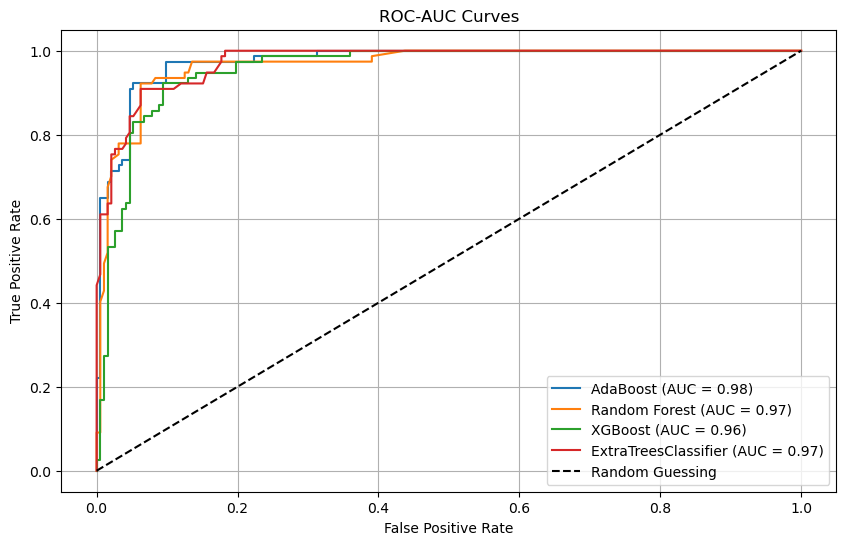

In [17]:
models = {'AdaBoost': adaboost_clf,'Random Forest':rf,'XGBoost': xgboost_clf,'ExtraTreesClassifier':et}

roc_auc_scores = {}
roc_curves = {}

# Train models, calculate ROC-AUC scores and curves
for name, model in models.items():
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    roc_auc_scores[name] = roc_auc_score(y_test, y_scores)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_curves[name] = (fpr, tpr)

# Plot ROC-AUC curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend()
plt.grid()
plt.show()

**ROC-AUC Curves Analysis**

The ROC-AUC curves illustrate that AdaBoost, Random Forest, and ExtraTreesClassifier all achieve an AUC score of 0795, indicating excellent model performance in distinguishing between classes. XGBoost, while slightly lower with an AUC score of 0693, still demonstrates strong classification ability. The close performance among AdaBoost, Random Forest, and ExtraTreesClassifier suggests comparable efficacy, with only minor differences in their ROC curves.


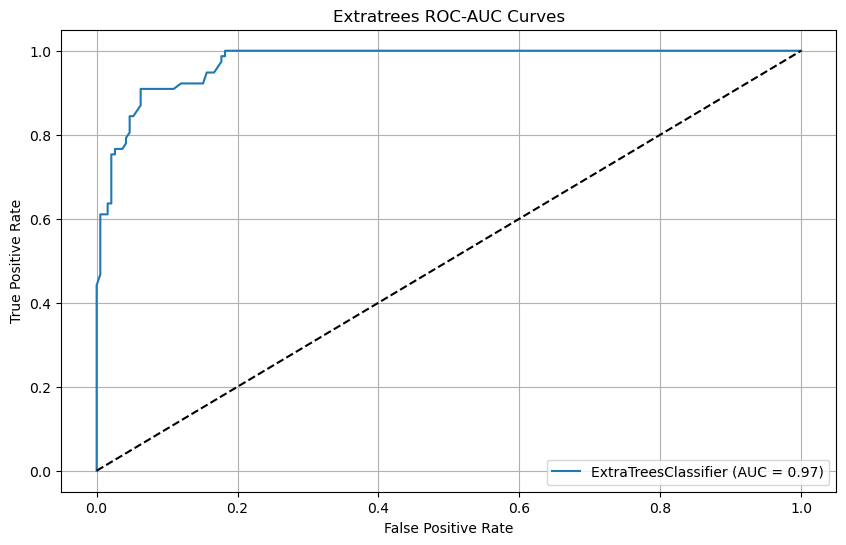

In [18]:
model_et = {'ExtraTreesClassifier':et}

roc_auc_scores = {}
roc_curves = {}

# Train models, calculate ROC-AUC scores and curves
for name, model in model_et.items():
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    roc_auc_scores[name] = roc_auc_score(y_test, y_scores)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_curves[name] = (fpr, tpr)

# Plot ROC-AUC curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extratrees ROC-AUC Curves')
plt.legend()
plt.grid()
plt.show()

#### Confusion Matrix

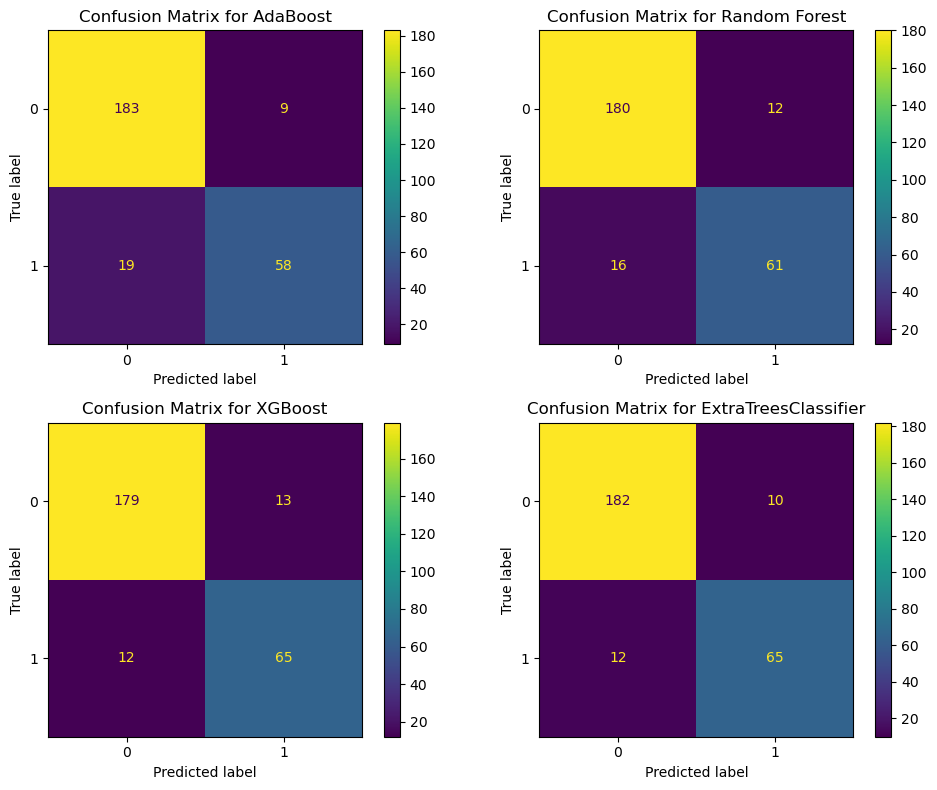

In [19]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Loop through the models and generate confusion matrices
for i, (name, model) in enumerate(models.items(), start=1):
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    
    # Plot the confusion matrix
    plt.subplot(2, 2, i)
    plt.title(f"Confusion Matrix for {name}")
    cmd.plot(ax=plt.gca())  # Use current axis for plotting
    
# Adjust layout and display the plots
plt.tight_layout()
plt.show()

**Confusion Matrix Analysis**

The confusion matrices reveal that AdaBoost and ExtraTreesClassifier correctly predict the majority of trupositiveses (382 and8278, respectively) and trunegativeses5860 and 65, respectively), demonstrating their strong predictive performance. XGBoost, while effective with564 true positives, has a higher false positive rate 317) compared to the other models. Random Forest shows balanced performance with slightly more false positives 213) and false negatives 618) compared to AdaBoost, but maintains a strong overall prediction capabilit Overall ExtraTreesClassifier outforms on the basis of consistencyy.


#### Plot of Accuracy and F1 Score

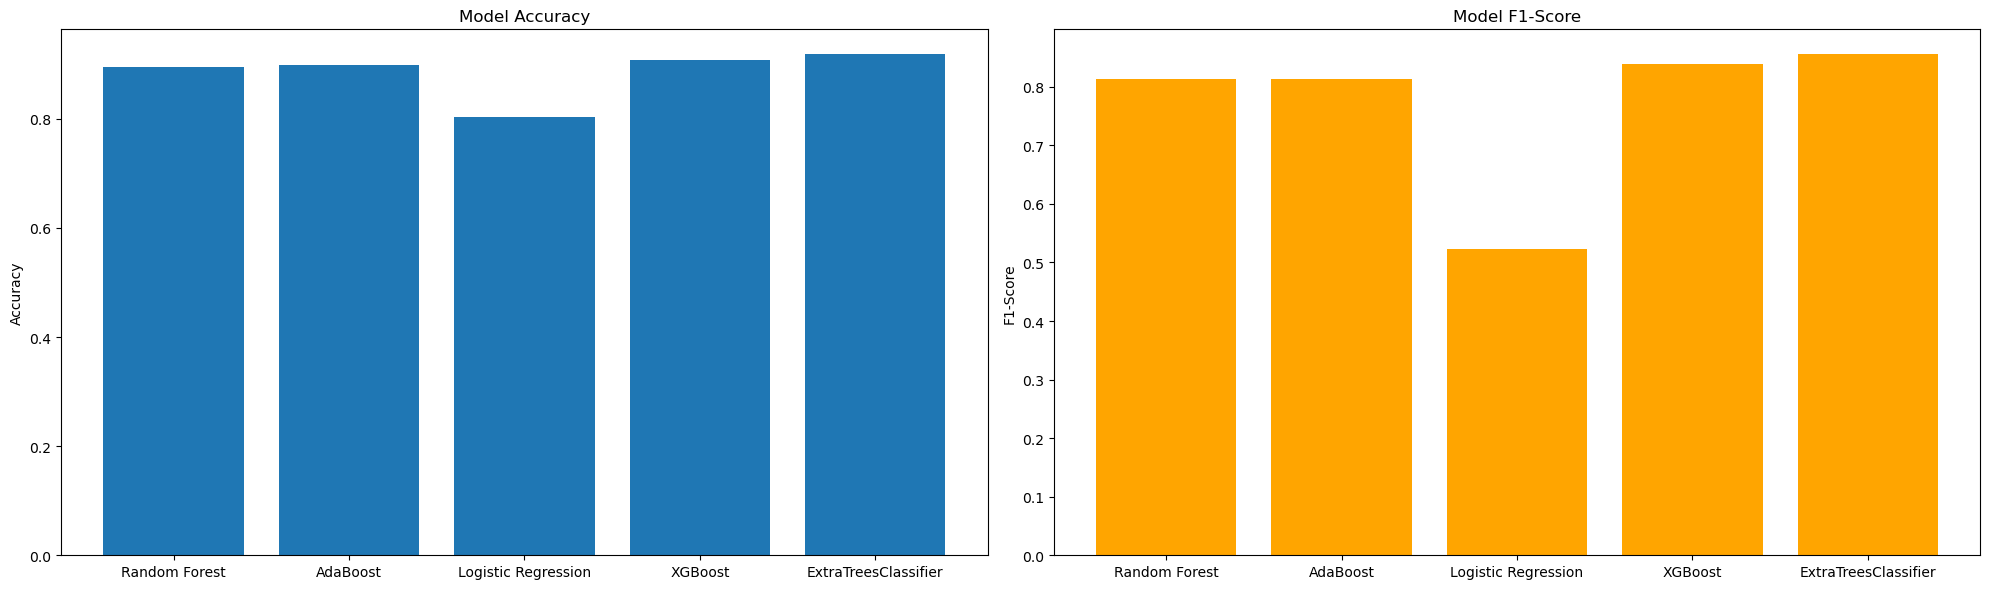

In [20]:
# Plot bar graphs for accuracy and F1-score
plt.figure(figsize=(20, 6))

# Bar graph for Accuracy
plt.subplot(1, 2, 1)
plt.bar(results_df_test['Model'], results_df_test['Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# Bar graph for F1-Score
plt.subplot(1, 2, 2)
plt.bar(results_df_test['Model'], results_df_test['F1-Score'], color='orange')
plt.title('Model F1-Score')
plt.ylabel('F1-Score')

plt.tight_layout()
plt.show()

**Model Comparison on Accuracy and F1-Score**

The bar charts highlight that Random Forest, AdaBoost, and ExtraTreesClassifier achieve the highest accuracy, each around 0.90, while Logistic Regression significantly lags behind. In terms of F1-score, ExtraTreesClassifier and AdaBoost lead, both exceeding 0.80, indicating their balanced precision and recall. Logistic Regression performs the worst in both metrics, suggesting it is less effective for this classification task compared to the ensemble methods.


#### Plot of evaluation matrix for various models

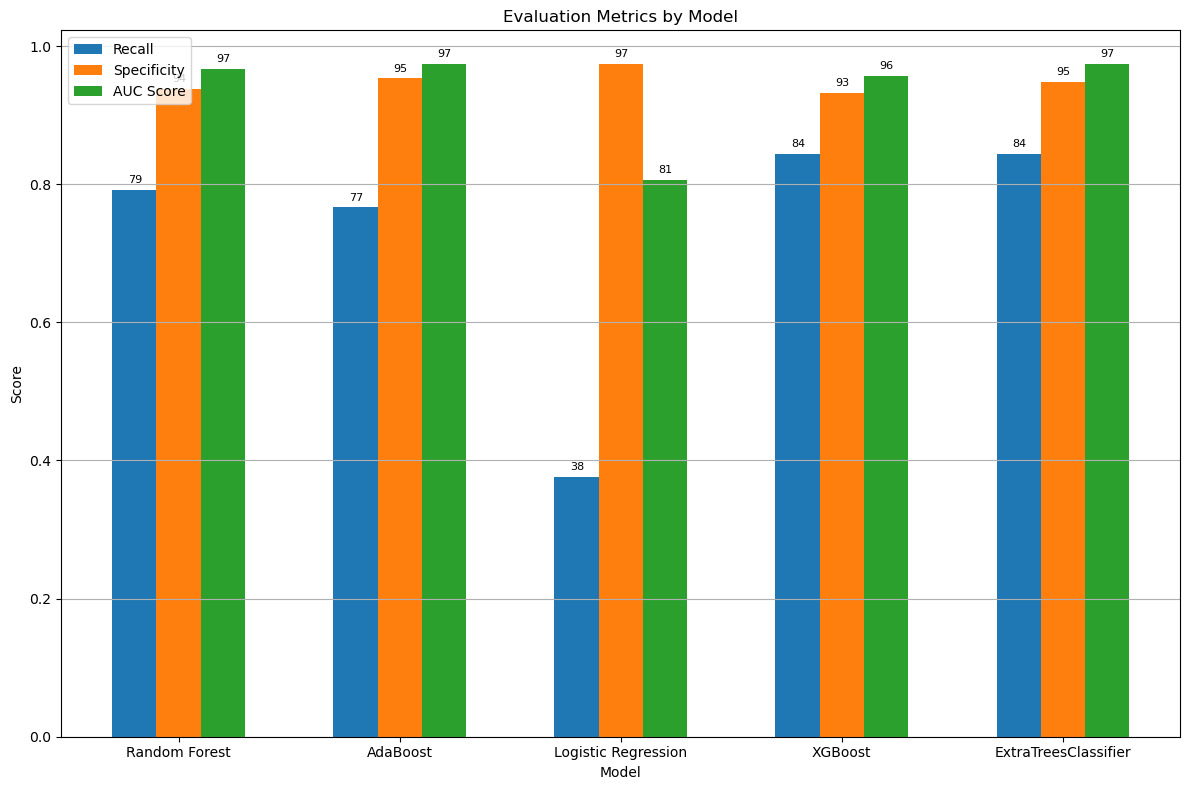

In [21]:
# Define evaluation metrics 
metrics = ['Recall','Specificity', 'AUC Score']

# Set the width of the bars
bar_width = 0.2

# Set the x locations for the groups
index = np.arange(len(results_df_test['Model']))

# Plot the bar chart
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, results_df_test[metric], bar_width, label=metric)
    # Annotate each bar with its value
    for j, value in enumerate(results_df_test[metric]):
        plt.text(index[j] + i * bar_width - 0.03, value + 0.01, f'{value * 100:.0f}', fontsize=8)

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Evaluation Metrics by Model')
plt.xticks(index + bar_width * (len(metrics) - 1) / 2, results_df_test['Model'])
plt.legend()
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

**Model Comparison of Evaluation Metrics of test set**

The bar graph shows the average evaluation metric by model. The evaluation metrics include recall, specificity, and AUC score. The recall is highest for the Extratrees model at 84, while the AUC score is highest for the Random Forest, AdaBoost, ExtraTrees model at 97. Overall, the ExtraTrees model appears to perform the best on this task.

#### Plot of cross validation metrix

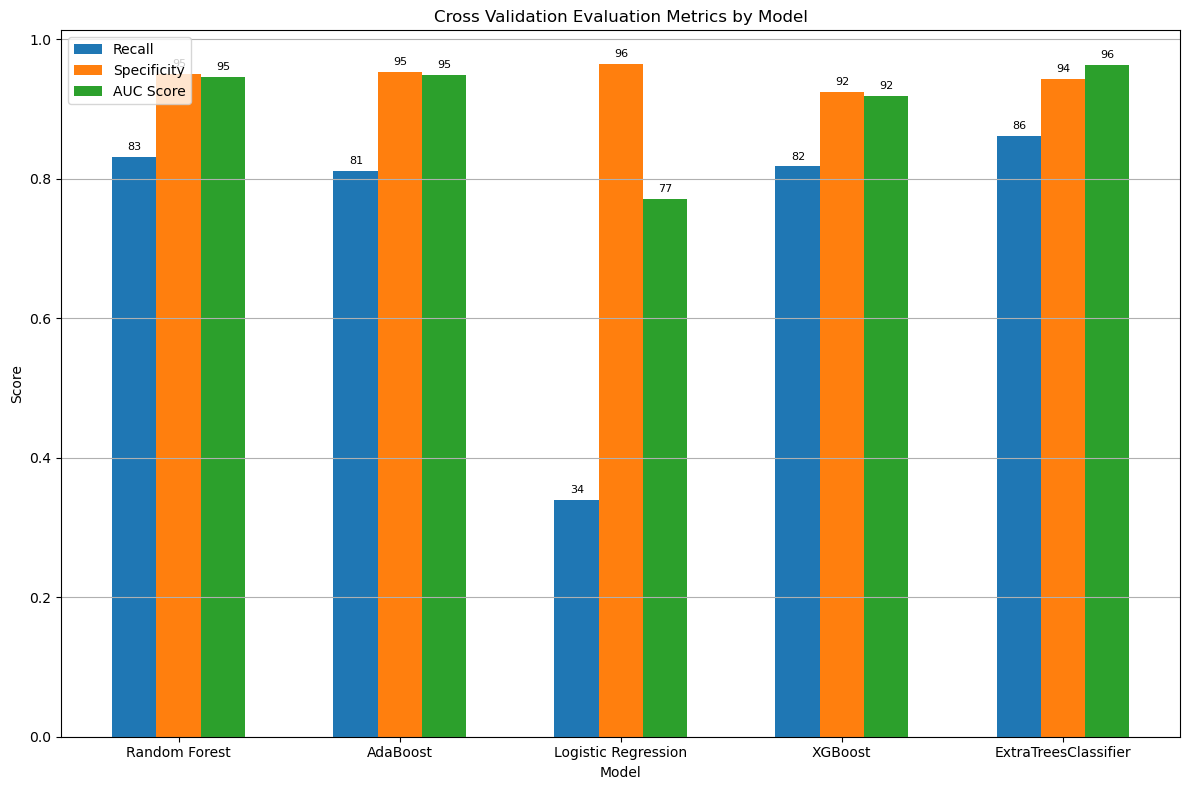

In [22]:
# Define evaluation metrics for cross validation with 10 folds
metrics = ['Recall','Specificity', 'AUC Score']

# Set the width of the bars
bar_width = 0.2

# Set the x locations for the groups
index = np.arange(len(cv_results_df['Model']))

# Plot the bar chart
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, cv_results_df[metric], bar_width, label=metric)
    # Annotate each bar with its value
    for j, value in enumerate(cv_results_df[metric]):
        plt.text(index[j] + i * bar_width - 0.03, value + 0.01, f'{value * 100:.0f}', fontsize=8)

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Cross Validation Evaluation Metrics by Model')
plt.xticks(index + bar_width * (len(metrics) - 1) / 2, cv_results_df['Model'])
plt.legend()
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

**Model Comparison for Cross Validation Evaluation Metrics of Test set**

The bar graph shows the average cross-validation evaluation metrics by model. The evaluation metrics include recall, specificity, and AUC score.  For all three metrics, the Random Forest model has the highest average score. Overall, the ExtraTrees model appears to perform the best on this task.

### Pickle File

In [23]:
# Train the Random Forest model
et.fit(X_train, y_train)

# Save the Random Forest model to a file
pickle.dump(et, open('extra_trees.pkl', 'wb'))

#### Load Pickle file for prediction

In [24]:
model_from_pickle = pickle.load(open('extra_trees.pkl','rb')) 

In [25]:
first_row = X_test.iloc[1]
first_row_reshaped = first_row.values.reshape(1, -1)
first_row

FEVER INTENSITY               1.0
FEVER DAYS                    3.0
HEADACHE DAYS                 0.0
BODYACHE DAYS                 1.0
VOMITING DAYS                 1.0
ABDOMINAL DISCOMFORT DAYS     0.0
COUGH DAYS                    0.0
URINAL VARIATION              0.0
pallor                        0.0
CHILLS DAYS                   1.0
RIGORS                        1.0
TEMP(f)                      98.4
Age                          24.0
Gender                        2.0
Name: 294, dtype: float64

In [26]:
model_from_pickle.predict(first_row_reshaped)

array([1], dtype=int64)